In [72]:
from abc import ABC

import pandas as pd
from joblib import load

# Load in the models
DT_demand_model = load("DT Demand Model.pkl")
RF_supply_model = load("RF Supply Model.pkl")

# Load in dataset
df_full = pd.read_csv("AA.Complete Data.csv")
df_full["DATE & TIME"] = pd.to_datetime(df_full["DATE & TIME"])
df_full.head(100)

,DATE & TIME,Solar Radiation (Wh/m)2,UV Intensity,Atmospheric Clarity,Temperature (2m),Humidity (2M),PS,Wind Speed (10m),Wind Direction (10m),MW Supply,MW Demand
0,2021-01-01 00:00:00,0.0,0.0,0.370000,8.03,6.65,93.99,3.62,85.05,0,204.89
1,2021-01-01 01:00:00,0.0,0.0,0.370000,8.01,6.65,94.00,3.50,91.92,0,191.17
2,2021-01-01 02:00:00,0.0,0.0,0.370000,8.03,6.65,94.00,3.41,98.58,0,182.21
3,2021-01-01 03:00:00,0.0,0.0,0.370000,8.01,6.59,93.98,3.33,101.65,0,171.64
4,2021-01-01 04:00:00,0.0,0.0,0.370000,7.92,6.59,93.98,3.26,104.87,0,168.28
...,...,...,...,...,...,...,...,...,...,...,...
95,2021-01-04 23:00:00,0.0,0.0,0.352857,10.65,6.71,94.16,3.85,100.53,0,204.75
96,2021-01-05 00:00:00,0.0,0.0,0.355000,10.35,6.65,94.11,3.80,102.69,0,197.47
97,2021-01-05 01:00:00,0.0,0.0,0.357143,9.70,6.59,94.08,3.30,104.70,0,185.29
98,2021-01-05 02:00:00,0.0,0.0,0.359286,9.70,6.53,94.09,3.14,104.87,0,176.89


In [73]:
def create_lag_features(data, columns, lags=3):
    lagged_dfs = []  # list to store lagged DataFrames

    for column in columns:
        for lag in range(1, lags + 1):
            lagged_col = data[column].shift(lag)
            lagged_col.name = f"{column}_lag{lag}"
            lagged_dfs.append(lagged_col)

    # Combine all lagged columns into one DataFrame
    # Helps prevent issues with pandas performance
    lagged_features = pd.concat(lagged_dfs, axis=1)

    # Combine with original data and drop NaNs caused by shifting
    data = pd.concat([data, lagged_features], axis=1).dropna()

    return data

# Specify the columns to generate lags for (not including DATE & TIME)
columns_to_lag = ['Solar Radiation (Wh/m)2', 'UV Intensity', 'Atmospheric Clarity',
                  'Temperature (2m)', 'Humidity (2M)', 'PS', 'Wind Speed (10m)',
                  'Wind Direction (10m)']

# Create lag features
df_lagged = create_lag_features(df_full, columns=columns_to_lag, lags=3)

X_predict = df_lagged.drop(columns =['DATE & TIME', 'MW Supply', 'MW Demand'])

In [74]:
predicted_supply = RF_supply_model.predict(X_predict)
predicted_demand = DT_demand_model.predict(X_predict)

In [75]:
import numpy as np

# Make any predictions below 0 just 0
threshold = 0.1
predicted_supply = predicted_supply.flatten()
predicted_supply = np.where(predicted_supply < threshold, 0, predicted_supply)

df_NSGA = pd.DataFrame({
    "Date & Time": pd.to_datetime(df_full["DATE & TIME"].iloc[:len(predicted_demand)]).dt.strftime('%m-%d %H:%M:%S'),
    "Demand (MW)": predicted_demand.flatten().round(2),
    "Supply (MW)": predicted_supply.round(0),
})
df_NSGA.head(100)

,Date & Time,Demand (MW),Supply (MW)
0,01-01 00:00:00,169.59,0.0
1,01-01 01:00:00,169.59,0.0
2,01-01 02:00:00,169.59,0.0
3,01-01 03:00:00,169.59,0.0
4,01-01 04:00:00,160.62,0.0
...,...,...,...
95,01-04 23:00:00,171.37,0.0
96,01-05 00:00:00,171.37,0.0
97,01-05 01:00:00,171.37,0.0
98,01-05 02:00:00,171.37,0.0


In [76]:
# Needed
df_NSGA["Needed (MW)"] = (df_NSGA["Demand (MW)"] - df_NSGA["Supply (MW)"]).clip(lower = 0).round(2)

# Excess
df_NSGA["Excess (MW)"] = (df_NSGA["Supply (MW)"] - df_NSGA["Demand (MW)"]).clip(lower = 0).round(2)

df_NSGA.head(100)

,Date & Time,Demand (MW),Supply (MW),Needed (MW),Excess (MW)
0,01-01 00:00:00,169.59,0.0,169.59,0.0
1,01-01 01:00:00,169.59,0.0,169.59,0.0
2,01-01 02:00:00,169.59,0.0,169.59,0.0
3,01-01 03:00:00,169.59,0.0,169.59,0.0
4,01-01 04:00:00,160.62,0.0,160.62,0.0
...,...,...,...,...,...
95,01-04 23:00:00,171.37,0.0,171.37,0.0
96,01-05 00:00:00,171.37,0.0,171.37,0.0
97,01-05 01:00:00,171.37,0.0,171.37,0.0
98,01-05 02:00:00,171.37,0.0,171.37,0.0



### CO2 prodcut is based on oil and the amount of co2 produced for 1MW, due to SA using 90% crude oil for energy <br>
https://en.wikipedia.org/wiki/Energy_in_Saudi_Arabia#:~:text=Energy%20in%20Saudi%20Arabia%20involves,nearly%2075%25%20of%20government%20revenue. <br>
https://www.eeagrants.gov.pt/media/2776/conversion-guidelines.pdf -- CO2 prodduct values <br>
### For calcualting battery size and cost i used the following link as a guide line for the size and cist per battery and then the other link to see how Sakaah system size for it's farm <br>
https://www.vest.energy/blog/solar-storage-farmers <br>
https://www.pv-magazine.com/2019/11/27/saudi-arabias-300-mw-sakaka-solar-plant-comes-online/ <br>
as the max excess is only 100 across the whole year, I looked into the price of <br>
### For selling i used the following website to gather the sell price for per watts per hour<br>
https://www.linkedin.com/pulse/saudi-arabia-regulation-small-scale-solar-daniel-c-domingues/

# Creating The NSGA Problem
**store_ratio is the single decision variable**
- This is what will be changing to decide how much energy is stored for CO2 offset or selling for profit

**Objective formulation (["F"] = [total_co2, -total_profit]):**
- This is the end goal
    - Minimize CO2 Production
    - Maximize Profit

**_evaluate() - creates the logic for the scenario**
- loops through the whole df of supply and demand
- looks at if supply > demand
    - applies Excess logic of using the decision var (store_ratio) to split it into store and sell
- else:
    - applies Deficit logic of checking excesses storage first and then looks at using fossil fuel instead which adds to the total CO2 production


In [77]:
from pymoo.core.problem import ElementwiseProblem

# £
SELL_PRICE_PER_MW = 15
# KG
CO2_PER_MW = 590

class CO2andProfitNSGA2(ElementwiseProblem):
    def __init__(self, df, sell_price=SELL_PRICE_PER_MW, co2_per_mwh= CO2_PER_MW):
        self.df = df.reset_index(drop=True)
        self.sell_price = sell_price
        self.co2_per_mwh = co2_per_mwh

        super().__init__(n_var=1, n_obj=2, n_constr=0, xl=0.0, xu=1.0)

    def _evaluate(self, x, out, *args, **kwargs):
        store_ratio = x[0]
        storage = 0.0
        total_profit = 0.0
        total_co2 = 0.0

        for i in range(len(self.df)):
            demand = self.df["Demand (MW)"].iloc[i]
            supply = self.df["Supply (MW)"].iloc[i]

            if supply > demand:
                # Excess energy — decide how much to store vs sell
                excess = supply - demand
                to_store = store_ratio * excess
                to_sell = (1 - store_ratio) * excess

                storage += to_store
                total_profit += to_sell * self.sell_price

            else:
                # Deficit — try to use storage first, otherwise fossil fuel
                shortfall = demand - supply
                if storage >= shortfall:
                    storage -= shortfall
                else:
                    fossil_needed = shortfall - storage
                    total_co2 += fossil_needed * self.co2_per_mwh
                    storage = 0.0

        out["F"] = [total_co2, -total_profit]  # Minimise CO₂, maximise profit

# Using NSGA with the custom problem scenario

In [78]:
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

problem = CO2andProfitNSGA2(df_NSGA)

algorithm = NSGA2(
    pop_size = 50,                          # How many solutions generated in each generation
    sampling = FloatRandomSampling(),       # Generate random float values (store_ratio will be the target for this)
    crossover = SBX(prob = 0.9, eta = 15),  # prob (90% of the generation will undergo crossover) | eta (How similar offspring are to parents)
    mutation = PM(eta = 20),                # The chance of mutation within each solution
    eliminate_duplicates = True,            # Makes sure identical solutions aren't duplicated
)

result = minimize(
    problem,
    algorithm,
    ('n_gen', 100),                         # How many generations
    seed = 1,                               # Like random_state = 42 (keeps the randomness the same each time it is run)
    verbose = True                          # Just prints progress
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |     50 |             - |             -
     2 |      100 |     50 |  0.0077788818 |         ideal
     3 |      150 |     50 |  0.0050694735 |             f
     4 |      200 |     50 |  0.0038441272 |             f
     5 |      250 |     50 |  0.0031346662 |             f
     6 |      300 |     50 |  0.0037803604 |             f
     7 |      350 |     50 |  0.0046624008 |             f
     8 |      400 |     50 |  0.0043328028 |             f
     9 |      450 |     50 |  0.0059224702 |             f
    10 |      500 |     50 |  0.0052950718 |             f
    11 |      550 |     50 |  0.0030984906 |             f
    12 |      600 |     50 |  0.0036915255 |             f
    13 |      650 |     50 |  0.0055841670 |             f
    14 |      700 |     50 |  0.0044795159 |             f
    15 |      750 |     50 |  0.0055877160 |             f
    16 |      800 |     50 |  0.0041531927 |            

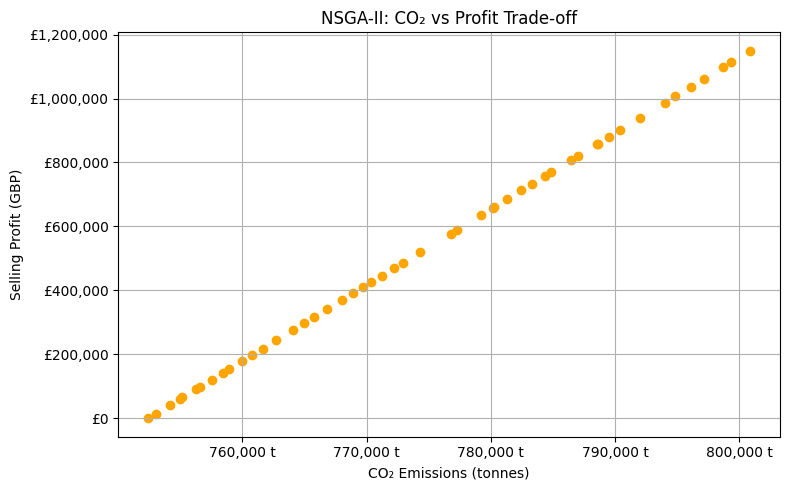

In [86]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

F = result.F

plt.figure(figsize=(8, 5))
plt.scatter(F[:, 0] / 1000, -F[:, 1], c='orange')  # Convert kg to tonnes

# y-axis as £
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"£{int(x):,}"))

# x-axis as tonnes
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,} t"))

plt.xlabel("CO₂ Emissions (tonnes)")
plt.ylabel("Selling Profit (GBP)")
plt.title("NSGA-II: CO₂ vs Profit Trade-off")
plt.grid(True)
plt.tight_layout()
plt.show()
